# Solving the OLG model with an iterative, binary search algorithm

Imports and set magics:

In [1]:
import numpy as np

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# local modules
import modelproject

First step is to set up our OLG model. This means defining consumption functions for young and old agents, defining a cummulative, log utility function to be maximized and defining parameter values for the wage, interest rate and utility discount rate.

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
wage = 1.0  # Wage when young
interest_rate = 0.04  # Initial interest rate
beta = 0.96  # Initial discount factor
num_iterations = 100  # Number of iterations for the algorithm
tolerance = 1e-6  # Convergence tolerance

# Utility function: log utility
def utility(c):
    return np.log(c)

# Objective function for young agents
def objective_savings(s, wage, interest_rate, beta):
    c_y = wage - s  # Consumption while young
    c_o = (1 + interest_rate) * s  # Consumption while old
    
    if c_y <= 0 or c_o <= 0:
        return -np.inf  # Invalid consumption levels
    
    # Total utility: current utility + discounted future utility
    total_utility = utility(c_y) + beta * utility(c_o)
    return total_utility



The next step is to create an algorithm that can solve the model by finding the optimal savings level (indirectly, we are also finding the optimal consumption level this way). We have chosen a binary search, iterative algorithm that works in the following way:

The algorithm starts by defining the lower and upper bounds of the savings (s_lower and s_upper). In this OLG model, the bounds are set between a very small number close to zero, to ensure positive consumption, and the wage, to ensure savings do not exceed income.

Each iteration of the algorithm involves calculating the midpoint, s_mid, of the current s_lower and s_upper. The utility is then evaluated at three points, s_lower, s_mid and s_upper, based on the given utility function and the given value of savings.

Next, the algorithm computes the change in utiltiy between s_lower and s_mid and s_mid and s_upper. If the change in utility between s_lower and s_mid is greater than s_mid to s_upper the algorithm adjusts s_upper to s_mid. Otherwise, it adjusts s_lower to s_mid. This iterative search continues until the difference between s_lower and s_upper falls below a predefined tolerance level given by 'tolerance'. When the algorithm breaks, the optimal savings level is then found as the average of s_lower and s_upper (these two numbers will be almost identical at this point).

Since we compute a change in utiltiy and not a formal derivative, we could use any utiltiy function in our model, including ones that might not be differentiable. 

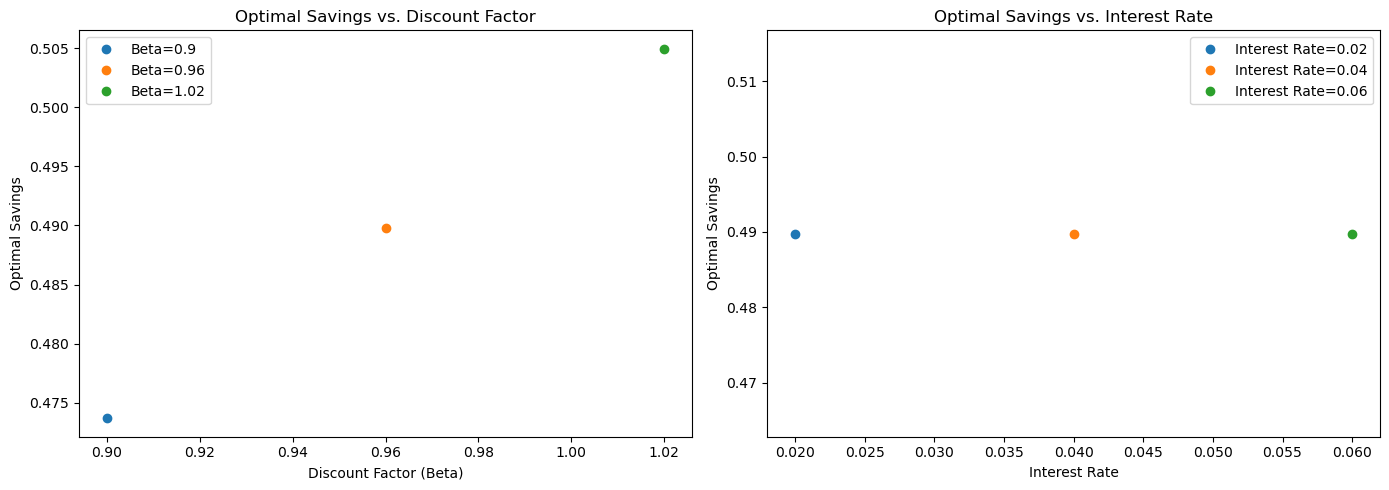

In [4]:
# Iterative algorithm to find optimal savings
def find_optimal_savings(wage, interest_rate, beta):
    s_lower, s_upper = 0.01, wage  # Set search bounds for savings
    for _ in range(num_iterations):
        s_mid = (s_lower + s_upper) / 2.0
        grad_left = (objective_savings(s_lower, wage, interest_rate, beta) - 
                     objective_savings(s_mid, wage, interest_rate, beta)) / (s_mid - s_lower)
        grad_right = (objective_savings(s_upper, wage, interest_rate, beta) - 
                      objective_savings(s_mid, wage, interest_rate, beta)) / (s_upper - s_mid)
        
        # Determine which direction to adjust bounds
        if grad_left > grad_right:
            s_upper = s_mid
        else:
            s_lower = s_mid
        
        # Check for convergence
        if abs(s_upper - s_lower) < tolerance:
            break
    
    # Return optimal savings as the average between the lower and upper bounds
    optimal_savings = (s_lower + s_upper) / 2.0
    return optimal_savings

# Plot the optimal savings solution for different parameter values
def plot_savings_solution():
    # Base parameters
    betas = [0.90, 0.96, 1.02,]  # Range of discount factors
    interest_rates = [0.02, 0.04, 0.06]  # Range of interest rates
    
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot for discount factors
    for b in betas:
        optimal_s = find_optimal_savings(wage, interest_rate, b)
        axs[0].plot([b], [optimal_s], 'o', label=f'Beta={b}')
    axs[0].set_xlabel('Discount Factor (Beta)')
    axs[0].set_ylabel('Optimal Savings')
    axs[0].legend()
    axs[0].set_title('Optimal Savings vs. Discount Factor')
    
    # Plot for interest rates
    for r in interest_rates:
        optimal_s = find_optimal_savings(wage, r, beta)
        axs[1].plot([r], [optimal_s], 'o', label=f'Interest Rate={r}')
    axs[1].set_xlabel('Interest Rate')
    axs[1].set_ylabel('Optimal Savings')
    axs[1].legend()
    axs[1].set_title('Optimal Savings vs. Interest Rate')
    
    plt.tight_layout()
    plt.show()

# Visualize the savings solution
plot_savings_solution()

Plotting the optimal savings level for different parameter values we notice a few things:
The optimal savings level is increasing in the discount factor 'beta'. This makes intuitive sense, as a higher discount factor means that the economic agent places a higher value on future consumption, making it more preferable to save more and consume less today. 

Changes in the interest rate does not affect the optimal savings level. This is due to our chosen utility function. With log utility, it holds that the income effect from a change in the interest rate equals the substituion effect. This means that the total change in the optimal savings level comes out to zero. 

We will now extend the model by relaxing the assumption of log utility. To do this we replace the log utility function with a more general CRRA (Constant relative risk aversion) utility function. We use our chosen algorithm from the previous section to solve the model again.

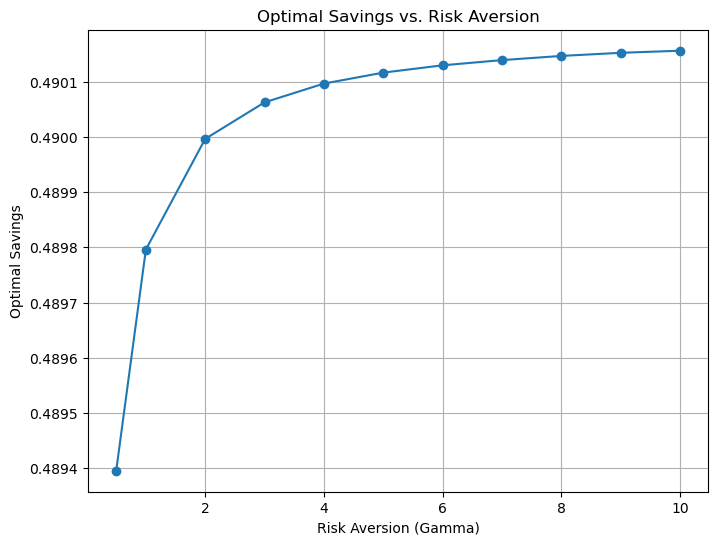

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# CRRA Utility Function
def utility_crra(c, gamma):
    if gamma == 1:
        return np.log(c)  # Special case: logarithmic utility
    else:
        return (c**(1 - gamma) - 1) / (1 - gamma)

# Objective function for young agents with CRRA utility
def objective_savings_crra(s, wage, interest_rate, beta, gamma):
    c_y = wage - s  # Consumption while young
    c_o = (1 + interest_rate) * s  # Consumption while old
    
    if c_y <= 0 or c_o <= 0:
        return -np.inf  # Invalid consumption levels
    
    # Total utility: current + discounted future
    total_utility = utility_crra(c_y, gamma) + beta * utility_crra(c_o, gamma)
    return total_utility

# Finding optimal savings with the CRRA utility
def find_optimal_savings_crra(wage, interest_rate, beta, gamma):
    s_lower, s_upper = 0.01, wage  # Search bounds
    num_iterations = 100
    tolerance = 1e-6
    
    for _ in range(num_iterations):
        s_mid = (s_lower + s_upper) / 2.0
        grad_left = (objective_savings_crra(s_lower, wage, interest_rate, beta, gamma) - 
                     objective_savings_crra(s_mid, wage, interest_rate, beta, gamma)) / (s_mid - s_lower)
        grad_right = (objective_savings_crra(s_upper, wage, interest_rate, beta, gamma) - 
                      objective_savings_crra(s_mid, wage, interest_rate, beta, gamma)) / (s_upper - s_mid)
        
        if grad_left > grad_right:
            s_upper = s_mid
        else:
            s_lower = s_mid
        
        if abs(s_upper - s_lower) < tolerance:
            break
    
    optimal_savings = (s_lower + s_upper) / 2.0
    return optimal_savings

# Visualize optimal savings for different levels of risk aversion (gamma)
def plot_savings_crra():
    wage = 1.0
    interest_rate = 0.04
    beta = 0.96
    gammas = [0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]  # Different levels of risk aversion (gamma)
    
    optimal_savings_values = []
    for gamma in gammas:
        optimal_s = find_optimal_savings_crra(wage, interest_rate, beta, gamma)
        optimal_savings_values.append(optimal_s)
    
    plt.figure(figsize=(8, 6))
    plt.plot(gammas, optimal_savings_values, marker='o')
    plt.xlabel('Risk Aversion (Gamma)')
    plt.ylabel('Optimal Savings')
    plt.title('Optimal Savings vs. Risk Aversion')
    plt.grid(True)
    plt.show()

# Visualize the optimal savings for different utility functions, that is, different values of gamma
plot_savings_crra()

The plot above shows how the optimal savings level changes with changes in gamma. As gamma increases, agents become more risk averse. This means that they prioritize saving more strongly since they fear the uncertainty of future consumption more strongly.

Now we will investigate how the optimal savings level changes when the interest rate changes. The first case will be when gamma is less than 1. The second case will look at gamma greater than 1. We remember that gamma=1 corresponds to the log utiltiy function we first looked at where the income effect was equal to the substitution effect.

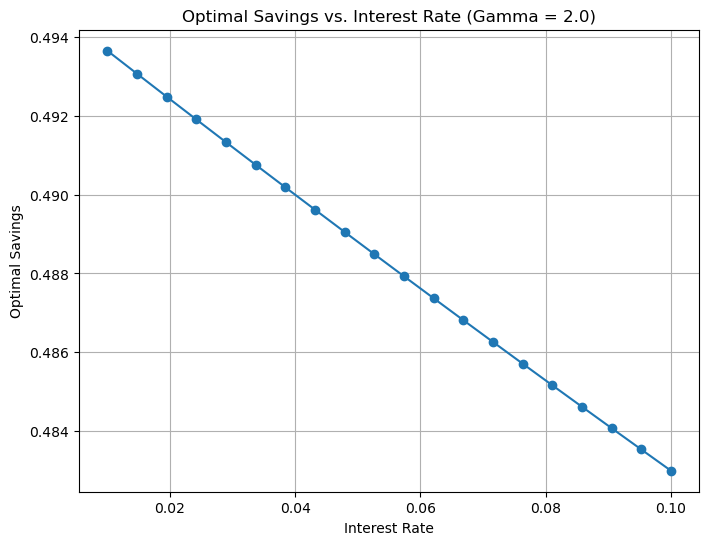

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# CRRA Utility Function (non-logarithmic case)
def utility_crra(c, gamma):
    return (c**(1 - gamma) - 1) / (1 - gamma)

# Objective function for young agents with CRRA utility
def objective_savings_crra(s, wage, interest_rate, beta, gamma):
    c_y = wage - s  # Consumption while young
    c_o = (1 + interest_rate) * s  # Consumption while old
    
    if c_y <= 0 or c_o <= 0:
        return -np.inf  # Invalid consumption levels
    
    total_utility = utility_crra(c_y, gamma) + beta * utility_crra(c_o, gamma)
    return total_utility

# Finding optimal savings with the CRRA utility
def find_optimal_savings_crra(wage, interest_rate, beta, gamma):
    s_lower, s_upper = 0.01, wage  # Search bounds
    num_iterations = 100
    tolerance = 1e-6
    
    for _ in range(num_iterations):
        s_mid = (s_lower + s_upper) / 2.0
        grad_left = (objective_savings_crra(s_lower, wage, interest_rate, beta, gamma) - 
                     objective_savings_crra(s_mid, wage, interest_rate, beta, gamma)) / (s_mid - s_lower)
        grad_right = (objective_savings_crra(s_upper, wage, interest_rate, beta, gamma) - 
                      objective_savings_crra(s_mid, wage, interest_rate, beta, gamma)) / (s_upper - s_mid)
        
        if grad_left > grad_right:
            s_upper = s_mid
        else:
            s_lower = s_mid
        
        if abs(s_upper - s_lower) < tolerance:
            break
    
    optimal_savings = (s_lower + s_upper) / 2.0
    return optimal_savings

# Visualize optimal savings for different interest rates with a fixed CRRA gamma value
def plot_savings_interest_rate():
    wage = 1.0
    beta = 0.96
    gamma = 2.0  # Fixed level of risk aversion (non-logarithmic)
    interest_rates = np.linspace(0.01, 0.1, 20)  # Interest rate range from 0.01 to 0.1
    
    optimal_savings_values = [find_optimal_savings_crra(wage, r, beta, gamma) for r in interest_rates]
    
    plt.figure(figsize=(8, 6))
    plt.plot(interest_rates, optimal_savings_values, marker='o')
    plt.xlabel('Interest Rate')
    plt.ylabel('Optimal Savings')
    plt.title(f'Optimal Savings vs. Interest Rate (Gamma = {gamma})')
    plt.grid(True)
    plt.show()

# Visualize how interest rates affect the optimal savings with CRRA utility
plot_savings_interest_rate()

The plot above shows that for gamma greater than 1 the optimal savings level is decreasing in the interest rate. This is because the substitution effect is weak for gamma greater than 1. In this case the income effect, where higher interest rates increase the overall lifetime wealth and allow for more consumption in both periods, dominates. This happens because the agent views the additional income as a reason to increase consumption today without significantly altering future consumption plans.

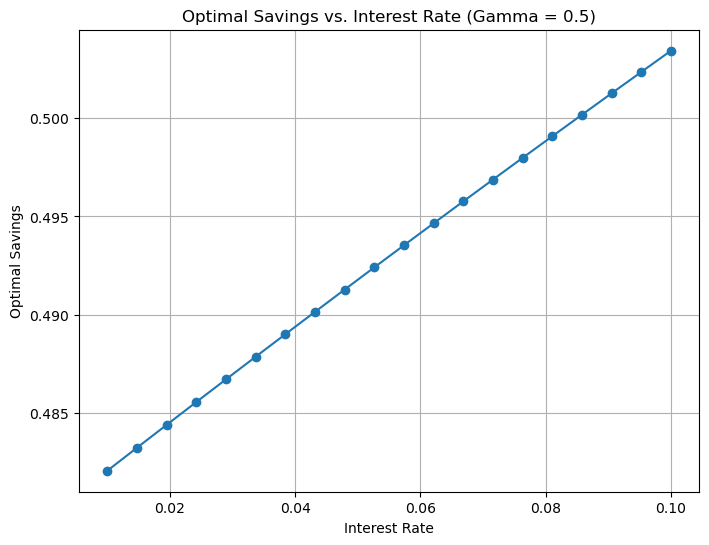

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# CRRA Utility Function (non-logarithmic case)
def utility_crra(c, gamma):
    return (c**(1 - gamma) - 1) / (1 - gamma)

# Objective function for young agents with CRRA utility
def objective_savings_crra(s, wage, interest_rate, beta, gamma):
    c_y = wage - s  # Consumption while young
    c_o = (1 + interest_rate) * s  # Consumption while old
    
    if c_y <= 0 or c_o <= 0:
        return -np.inf  # Invalid consumption levels
    
    total_utility = utility_crra(c_y, gamma) + beta * utility_crra(c_o, gamma)
    return total_utility

# Finding optimal savings with the CRRA utility
def find_optimal_savings_crra(wage, interest_rate, beta, gamma):
    s_lower, s_upper = 0.01, wage  # Search bounds
    num_iterations = 100
    tolerance = 1e-6
    
    for _ in range(num_iterations):
        s_mid = (s_lower + s_upper) / 2.0
        grad_left = (objective_savings_crra(s_lower, wage, interest_rate, beta, gamma) - 
                     objective_savings_crra(s_mid, wage, interest_rate, beta, gamma)) / (s_mid - s_lower)
        grad_right = (objective_savings_crra(s_upper, wage, interest_rate, beta, gamma) - 
                      objective_savings_crra(s_mid, wage, interest_rate, beta, gamma)) / (s_upper - s_mid)
        
        if grad_left > grad_right:
            s_upper = s_mid
        else:
            s_lower = s_mid
        
        if abs(s_upper - s_lower) < tolerance:
            break
    
    optimal_savings = (s_lower + s_upper) / 2.0
    return optimal_savings

# Visualize optimal savings for different interest rates with a fixed CRRA gamma value
def plot_savings_interest_rate():
    wage = 1.0
    beta = 0.96
    gamma = 0.5  # Fixed level of risk aversion (non-logarithmic)
    interest_rates = np.linspace(0.01, 0.1, 20)  # Interest rate range from 0.01 to 0.1
    
    optimal_savings_values = [find_optimal_savings_crra(wage, r, beta, gamma) for r in interest_rates]
    
    plt.figure(figsize=(8, 6))
    plt.plot(interest_rates, optimal_savings_values, marker='o')
    plt.xlabel('Interest Rate')
    plt.ylabel('Optimal Savings')
    plt.title(f'Optimal Savings vs. Interest Rate (Gamma = {gamma})')
    plt.grid(True)
    plt.show()

# Visualize how interest rates affect the optimal savings with CRRA utility
plot_savings_interest_rate()

The plot above shows that for values of gamma belove 1 the optimal savings level is increasing in the interest rate. This is beacuse the substitution effect is strong for gamma smaller than 1. An increase in interest rates significantly encourages more savings today to take advantage of higher future returns. Individuals are more willing to forego current consumption because they can substitute it with future consumption more easily.

# Conclusion

This project has shown how a 2 period OLG model can be solved with an iterative, binary search algorithm to find the optimal level of savings given some parameter values. We have shown how the solution changes with parameter value changes, and we have extended the model to investigate how different utility functions impact the solution. 